2024-04-30 07:17:14.598375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 07:17:14.622979: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 07:17:16.370246: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 07:17:20.222003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 07:17:30.801768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

At minute 0.0, no task is running.
At minute 1.0, no task is running.
At minute 2.0, no task is running.
At minute 3.0, no task is running.
At minute 4.0, no task is running.
At minute 5.0, no task is running.
At minute 6.0, no task is running.
At minute 7.0, no task is running.
At minute 8.0, no task is running.
At minute 9.0, no task is running.
At minute 10.0, a task is running.
At minute 11.0, a task is running.
At minute 12.0, a task is running.
At minute 13.0, a task is running.
At minute 14.0, a task is running.
At minute 15.0, a task is running.
At minute 16.0, no task is running.
At minute 17.0, no task is running.
At minute 18.0, no task is running.
At minute 19.0, no task is running.
At minute 20.0, no task is running.
At minute 21.0, no task is running.
At minute 22.0, no task is running.
At minute 23.0, no task is running.
At minute 24.0, no task is running.
At minute 25.0, no task is running.
At minute 26.0, no task is running.
At minute 27.0, no task is running.
At minut

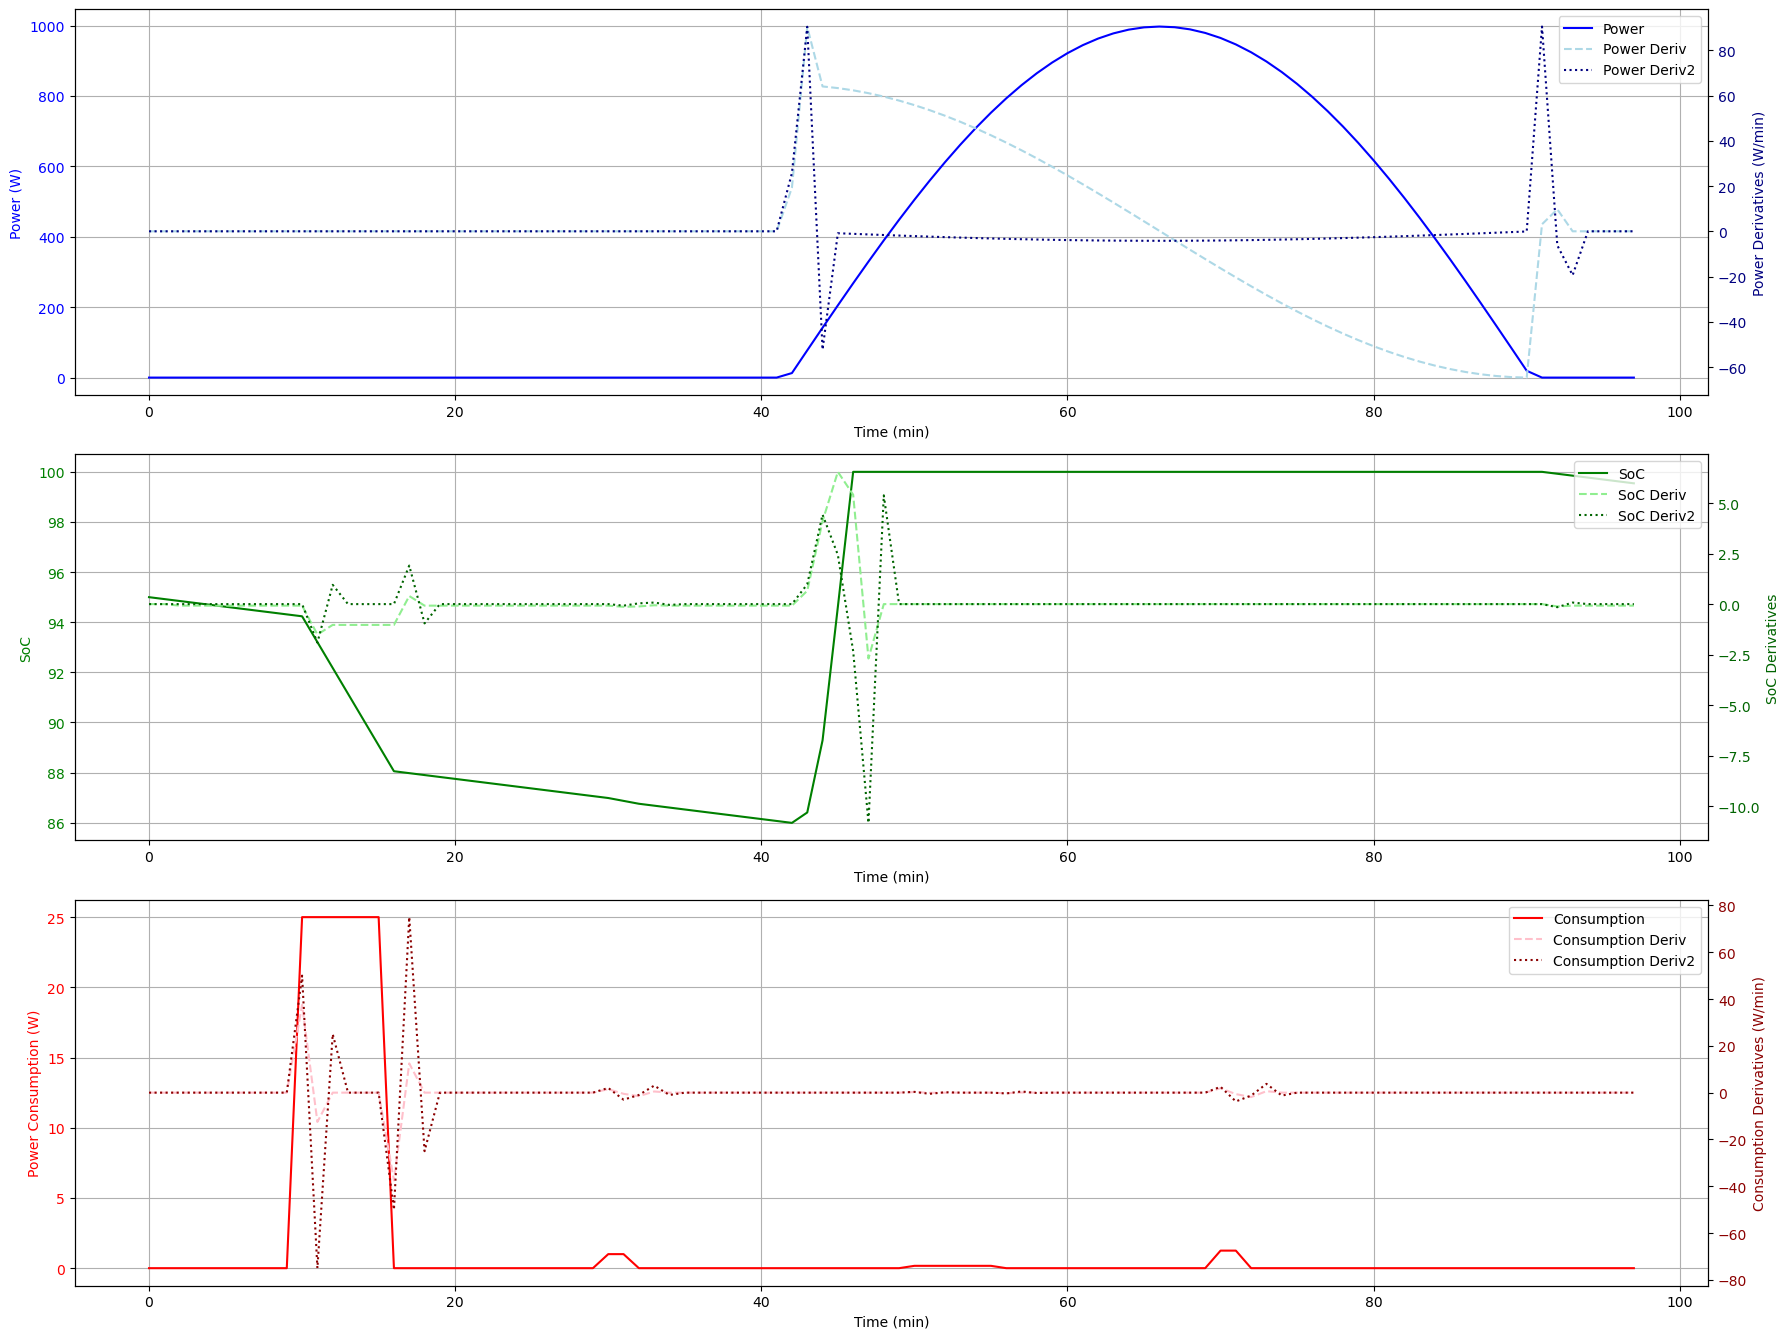

Time in each SoC range: {'0%-10%': 0, '10%-20%': 0, '20%-30%': 0, '30%-40%': 0, '40%-50%': 0, '50%-60%': 0, '60%-70%': 0, '70%-80%': 0, '80%-90%': 30.0, '90%-100%': 68.0}
Performance score: 100.0
State Vector: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 12.875419379444244 77.39379929908186
 141.5875627282118 205.1874587141018 267.92672719046016 329.5422178618593
 389.775493947526 448.37391615501315 505.09170233719095 559.6909583879865
 611.9426760529393 661.627693469407 708.5376144075794 752.4756823566922
 793.257605790208 830.7123311485261 864.6827602970562 895.0264094503899
 921.6160067988147 944.3400263305128 963.1031556104128 977.8266955536662
 988.4488905169591 994.9251873231417 997.2284221327365 995.3489343785212
 989.2946072853056 979.0908348049456 964.780415105286 946.4233710597692
 924.0966984906464 897.8940432217404 867.9253082953143 834.3161930005231

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chisquare
from math import pi, cos
from keras.models import Sequential
from keras.layers import Dense, Input
from math import exp, pi, cos  # Make sure exp is imported here
import tensorflow as tf

phase = np.random.rand() * 2 * pi
PtBatMax, PtMaxPanel = 43.68, 24.24
K, Eff = 191.1, 21.528 / 100
TInitial, TFinal, Dt = 0.0, 97.0, 1.0
SocInitial, HardDeck, SoftDeck = 95, 20, 30
NomConsum = 2
VOLTAGE = 12.0

TasksDf = pd.DataFrame({
    'TaskID': [1, 2, 3, 4],
    'Power': [1.5, 2.0, 1.0, 2.5],
    'StartTime': [10, 30, 50, 70],
    'Duration': [5, 1, 5, 1],
    'PriorityTransmission': [0.2, 1, 0.4, 0.3],
    'PriorityExecution': [0.2, 1, 0.1, 0.9]
})

# Define the dispersion (σ) as a constant for now
sigma = 1  # Adjust this as necessary

# Define the g(k) function
def g(k):
    if k == 1:
        return 1
    elif k == 2:
        return 0.5
    elif k == 3:
        return 0.25
    else:
        return 0

def task_reward(task, t_required, t_actual, sigma, d, k):
    s_j = 1 if task['TaskID'] in historical_task_status else 0
    p_j = task['PriorityExecution']
    t_f = t_actual - t_required
    gaussian_penalty = exp(-(t_f ** 2) / (2 * sigma ** 2))
    return s_j * p_j * gaussian_penalty * d * g(k)

# Define the overall reward function
def total_reward(tasks_df, historical_task_status, socs, E_max, E_L, alpha, sigma, k):
    Y_j_total = sum(task_reward(task, task['StartTime'], task['Duration'], sigma, 1, k) for _, task in tasks_df.iterrows())
    soc_penalty = alpha * sum(((E_i - E_L) / (E_max - E_L)) for E_i in socs)
    return Y_j_total - soc_penalty

def available_power(t, phase, k, efficiency, pt_max_panel):
    return max(pt_max_panel * cos(2 * pi * t / TFinal + phase) * efficiency * k, 0)

def execute_tasks(times, tasks_df):
    consumption = np.zeros(len(times))
    task_active = np.zeros(len(times), dtype=bool)
    data_generated = np.zeros(len(tasks_df))  # Vector to store data sizes generated
    historical_task_status = np.zeros((len(times), len(tasks_df)), dtype=int)  # Track historical active status for all tasks

    for index, task in tasks_df.iterrows():
        start_index = np.argmax(times >= task['StartTime'])
        end_index = np.argmax(times >= task['StartTime'] + task['Duration'])
        if start_index and end_index:
            consumption[start_index:end_index + 1] += task['Power'] / (end_index - start_index + 1)
            task_active[start_index:end_index + 1] = True
            data_generated[index] = np.random.randint(100, 501)  # Generates random data size between 100 and 500 KB
            historical_task_status[start_index:end_index + 1, index] = 1  # Mark as active during the task duration

    # Preserve historical status of tasks that have been executed
    for t in range(1, len(times)):
        historical_task_status[t] |= historical_task_status[t-1]
        
    return consumption, historical_task_status, task_active, data_generated

def is_task_running(times, task_active):
    for t, active in zip(times, task_active):
        if active:
            print(f"At minute {t}, a task is running.")
        else:
            print(f"At minute {t}, no task is running.")

def manage_soc(times, power, consumption, soc_initial, pt_bat_max, dt, nom_consum):
    soc = np.zeros(len(times))
    soc[0] = soc_initial
    for i in range(1, len(times)):
        energy_generated = power[i - 1] * dt / 60
        energy_consumed = (nom_consum + consumption[i - 1]) * dt / 60
        soc[i] = soc[i - 1] + (energy_generated - energy_consumed) * 100 / pt_bat_max
        soc[i] = max(0, min(100, soc[i]))
    return soc

def calculate_derivatives(data, dt):
    d1 = np.zeros(len(data))
    d2 = np.zeros(len(data))
    for i in range(2, len(data)):
        d1[i] = (3 * data[i] - 4 * data[i - 1] + data[i - 2]) / (2 * dt)
        if i > 2:
            d2[i] = (2 * data[i] - 5 * data[i - 1] + 4 * data[i - 2] - data[i - 3]) / dt**2
    return d1, d2

def sample_parameters(n):
    sampled_params = []
    for _ in range(n):
        k_sampled = norm.rvs(191.1, 5)
        eff_sampled = norm.rvs(0.21528, 0.01)
        sampled_params.append((k_sampled, eff_sampled))
    return sampled_params

def analyze_time_in_soc_ranges(socs, dt):
    ranges = np.arange(0, 110, 10)
    time_in_ranges = {}
    for i in range(len(ranges) - 1):
        range_key = f"{ranges[i]}%-{ranges[i+1]}%"
        time_in_ranges[range_key] = 0

    for soc in socs:
        for i in range(len(ranges) - 1):
            if ranges[i] <= soc < ranges[i+1]:
                range_key = f"{ranges[i]}%-{ranges[i+1]}%"
                time_in_ranges[range_key] += dt
                break

        if soc == 100:
            range_key = f"{ranges[-2]}%-{ranges[-1]}%"
            time_in_ranges[range_key] += dt

    return time_in_ranges

def evaluate_performance(time_in_ranges):
    performance_score = 0
    for range_key, time in time_in_ranges.items():
        if "20%-30%" in range_key:
            performance_score += time * 2
        elif "0%-20%" in range_key:
            performance_score += time * 5
        else:
            performance_score += time
    return performance_score

def print_historical_task_status(times, task_status):
    for time, status in zip(times, task_status):
        print(f"At minute {time}: Historical Task Status = {status}")

times = np.arange(TInitial, TFinal + Dt, Dt)
powers = [available_power(t, phase, K, Eff, PtMaxPanel) for t in times]
consumption, historical_task_status, task_active, data_generated = execute_tasks(times, TasksDf)
socs = manage_soc(times, powers, consumption, SocInitial, PtBatMax, Dt, NomConsum)
is_task_running(times, task_active)

power_derivs, power_derivs2 = calculate_derivatives(powers, Dt)
soc_derivs, soc_derivs2 = calculate_derivatives(socs, Dt)
consumption_derivs, consumption_derivs2 = calculate_derivatives(consumption, Dt)

plt.figure(figsize=(18, 13.5))

ax1 = plt.subplot(3, 1, 1)
p1, = ax1.plot(times, powers, label='Power', color='blue')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Power (W)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax1b = ax1.twinx()
p2, = ax1b.plot(times, power_derivs, label='Power Deriv', linestyle='--', color='lightblue')
p3, = ax1b.plot(times, power_derivs2, label='Power Deriv2', linestyle=':', color='navy')
ax1b.set_ylabel('Power Derivatives (W/min)', color='navy')
ax1b.tick_params(axis='y', labelcolor='navy')
ax1.legend(handles=[p1, p2, p3], loc='upper right')

ax2 = plt.subplot(3, 1, 2)
s1, = ax2.plot(times, socs, label='SoC', color='green')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('SoC', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True)

ax2b = ax2.twinx()
s2, = ax2b.plot(times, soc_derivs, label='SoC Deriv', linestyle='--', color='lightgreen')
s3, = ax2b.plot(times, soc_derivs2, label='SoC Deriv2', linestyle=':', color='darkgreen')
ax2b.set_ylabel('SoC Derivatives', color='darkgreen')
ax2b.tick_params(axis='y', labelcolor='darkgreen')
ax2.legend(handles=[s1, s2, s3], loc='upper right')

ax3 = plt.subplot(3, 1, 3)
c1, = ax3.plot(times, consumption, label='Consumption', color='red')
ax3.set_xlabel('Time (min)')
ax3.set_ylabel('Power Consumption (W)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.grid(True)

ax3b = ax3.twinx()
c2, = ax3b.plot(times, consumption_derivs, label='Consumption Deriv', linestyle='--', color='pink')
c3, = ax3b.plot(times, consumption_derivs2, label='Consumption Deriv2', linestyle=':', color='darkred')
ax3b.set_ylabel('Consumption Derivatives (W/min)', color='darkred')
ax3b.tick_params(axis='y', labelcolor='darkred')
ax3.legend(handles=[c1, c2, c3], loc='upper right')

plt.tight_layout()
plt.savefig('final_dynamic_plot.png')
plt.show()

time_in_ranges = analyze_time_in_soc_ranges(socs, Dt)
performance_score = 100 * evaluate_performance(time_in_ranges)/(TFinal + 1)
print("Time in each SoC range:", time_in_ranges)
print("Performance score:", performance_score)
tasks_vector = np.hstack((TasksDf['Power'].values, TasksDf['StartTime'].values, TasksDf['Duration'].values, TasksDf['PriorityTransmission'].values, TasksDf['PriorityExecution'].values))
neural_network_inputs = np.hstack((powers, power_derivs, power_derivs2, socs, soc_derivs, soc_derivs2), dtype=object)
state_vector = np.hstack((neural_network_inputs, tasks_vector))
print("State Vector:", state_vector)
print("Datos generados por cada tarea (KB):", data_generated)
print_historical_task_status(times, historical_task_status)

alpha = 0.5  # Example value for the weight of SOC goodness
k = 2  # Example value for the number of days since regen

Z = total_reward(TasksDf, historical_task_status, socs, PtBatMax, HardDeck, alpha, sigma, k)

print("Total Reward:", Z)